# NLP Text Clustering with DistilBERT Embeddings
* Notebook by Adam Lang
* Date: 8/12/2024

# Introduction
* In this notebook we will perform clustering using the DistilBERT embeddings.

# Workflow
1. Explore and evaluate benchmark/traditional methods.
2. Utilize HuggingFace Transformers library.
3. We will not assume any text pre-processing (using transformers).
4. Visualize clusters.

In [3]:
## imports
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans

import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
ls

drive/  sample_data/


In [5]:
## unzip file
!unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [6]:
## set data_path
data_path = '/content/drive/MyDrive/Colab Notebooks/Building LLM apps using prompt engineering/all_sentiment_shuffled.txt'

In [7]:
## read in the data with this function
def read_docs(doc_file):
  docs = []
  labels = []
  # open file
  with open(doc_file, encoding='utf-8') as f:
    for line in f:
      label, _, _, doc = line.strip().split(maxsplit=3)
      docs.append(doc)
      labels.append(label)
  return docs, labels

## Calculate Cluster Purity - Functon
* Cluster purity is a metric used to evaluate the quality of a clustering model by measuring how well clusters contain a single class. It's calculated by:
1. Assigning a label to each cluster based on the most frequent class in it
2. Counting the number of data points from the most common class in each cluster
3. Summing the counts over all clusters
4. Dividing the sum by the total number of data points
* A cluster is considered "pure" if it contains labeled objects from **only one class**, and impure if it contains labeled objects from multiple classes.
   * Purity increases as the number of clusters increases, and if a model groups each observation in a separate cluster, the purity becomes one.
   * However, purity can't be used to trade off the number of clusters against clustering quality.

In [8]:
## cluster purity
from collections import Counter

def purity(labels, clustered):

  # find set of cluster ids
  cluster_ids = set(clustered)

  N = len(clustered)
  majority_sum = 0
  for cl in cluster_ids:

    # for cluster compute frequencies of different human labels encountered
    # result will be --> {'camera':1, 'books':5, 'software':3}, etc..
    labels_cl = Counter(l for l, c in zip(labels, clustered) if c == cl)

    # select highest purity score and add to total sum
    majority_sum += max(labels_cl.values())

  # purity score is sum of majority counts dvidided by total number of items
  return majority_sum / N

In [9]:
## read in the data now
docs, labels = read_docs(data_path)

In [10]:
## lets view index of labels, docs
labels[1], docs[1]

('music',
 'i was misled and thought i was buying the entire cd and it contains one song')

We now have the label assigned to the corresponding document or sentence.

## Preprocessing

In [11]:
## setup tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# create sparse matrix
doc_matrix = vectorizer.fit_transform(docs)

In [12]:
## viewing the doc_matrix -- its a sparse matrix
doc_matrix

<11914x46619 sparse matrix of type '<class 'numpy.float64'>'
	with 579847 stored elements in Compressed Sparse Row format>

In [13]:
## fit a KMeans model to start
cluster_model = KMeans(n_clusters=7, random_state=42, n_init="auto", verbose=True)

# fit_predict
cluster_docs = cluster_model.fit_predict(doc_matrix)

Initialization complete
Iteration 0, inertia 22656.246482995735.
Iteration 1, inertia 11644.675177880315.
Iteration 2, inertia 11584.645484742608.
Iteration 3, inertia 11558.680884610008.
Iteration 4, inertia 11533.541240944869.
Iteration 5, inertia 11520.699303038265.
Iteration 6, inertia 11518.497889744493.
Iteration 7, inertia 11518.100498323594.
Iteration 8, inertia 11518.01328000992.
Iteration 9, inertia 11517.989341373595.
Iteration 10, inertia 11517.950518733436.
Iteration 11, inertia 11517.941308315736.
Iteration 12, inertia 11517.930842175085.
Iteration 13, inertia 11517.921899286375.
Iteration 14, inertia 11517.915017902613.
Iteration 15, inertia 11517.907669760532.
Iteration 16, inertia 11517.904038456063.
Iteration 17, inertia 11517.896376631203.
Iteration 18, inertia 11517.88495474695.
Iteration 19, inertia 11517.882701261964.
Converged at iteration 19: strict convergence.


### Evaluate the K=6 model above

In [14]:
purity(labels, cluster_docs)

0.6818029209333557

In [15]:
## evaluate the adjusted rand score
from sklearn.metrics.cluster import adjusted_rand_score

## print adjusted rand_score
adjusted_rand_score(labels, cluster_docs)

0.3177894612834487

Summary:
* We can see the purity is 68.1% and the adjusted rand_score is 31.7%.
* The adjusted_rand_score is the Rand index adjusted for chance.
   * The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
* Purity is an evaluation metric commonly used in the context of clustering with known ground truth labels.
   * It measures the agreement between the assigned clusters and the true labels of the data points.
   * Purity ranges from 0 to 1, with higher values indicating higher agreement.
   * A purity value of 1 indicates that all data points within a cluster share the same true label, demonstrating a highly accurate clustering solution.

**Interpretation of Results so far**
* So, based on our results above with the purity of 68.1% we can see there is a little over 50% probability of clusters sharing the same label, thus the clusters are not truly "pure".
* The Adjusted Rand Index (ARI) is a statistical measure used in data clustering analysis to compare the similarity between two partitions of a dataset.
   * It does this by comparing how data points are assigned to clusters.
   * The ARI value ranges from -0.5 to 1.0.
   * 1 indicates a perfect match
   * A value close to 0 indicates a random assignment.
* The adjusted Rand Index (ARI) should be interpreted as follows:
   * ARI >= 0.90 excellent recovery
   * 0.80 =< ARI < 0.90 good recovery
   * 0.65 =< ARI < 0.80 moderate recovery
   * ARI < 0.65 poor recovery.
* Thus the value of 0.31 above is closer to zero and we can predict it is a random assignment. We can definitely improve these results.

### Let's try using the `KElbowVisualizer` to find a better value of K
* There is an entire API/library that is available that uses different algorithms under the hood for finding the best K value rather than guessing or by random chance.
* The library is called "yellowbrick".

Initialization complete
Iteration 0, inertia 23377.656428484883.
Iteration 1, inertia 11747.842635377116.
Iteration 2, inertia 11736.812940267608.
Iteration 3, inertia 11731.56788871507.
Iteration 4, inertia 11725.20670018333.
Iteration 5, inertia 11723.174589371061.
Iteration 6, inertia 11722.368371084658.
Iteration 7, inertia 11721.869213399654.
Iteration 8, inertia 11721.512543952176.
Iteration 9, inertia 11721.242612294616.
Iteration 10, inertia 11721.055121487156.
Iteration 11, inertia 11720.79797680229.
Iteration 12, inertia 11720.086943407838.
Iteration 13, inertia 11717.098252001888.
Iteration 14, inertia 11713.113021664567.
Iteration 15, inertia 11712.849586802298.
Iteration 16, inertia 11712.817074054403.
Iteration 17, inertia 11712.794865648008.
Iteration 18, inertia 11712.777530788553.
Iteration 19, inertia 11712.769310966145.
Iteration 20, inertia 11712.765634033254.
Iteration 21, inertia 11712.763838163693.
Iteration 22, inertia 11712.761602349581.
Iteration 23, inertia 1

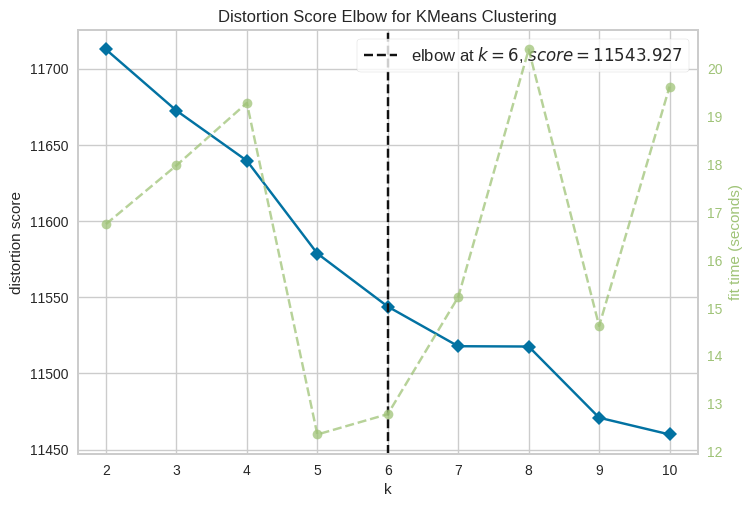

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
# model = KMeans()
# use the same model from above
visualizer = KElbowVisualizer(cluster_model, k=(2,11))

visualizer.fit(doc_matrix.toarray())    # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Summary:
* It looks like the k should be 6 based on this calculation.
* We could try other methods such as the Calinski Harabasz Score.
* Yellowbrick documentation is a good source for this methods: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

In [17]:
## lets try using 6 as the K and see if our results improve
## fit new kmeans model with n_clusters=6
cluster_model_2 = KMeans(n_clusters=6, random_state=42, n_init="auto", verbose=True)

# fit_predict
cluster_docs_2 = cluster_model.fit_predict(doc_matrix)

Initialization complete
Iteration 0, inertia 22344.431111184498.
Iteration 1, inertia 11580.847682611911.
Iteration 2, inertia 11519.6767434175.
Iteration 3, inertia 11501.106012156402.
Iteration 4, inertia 11489.249838362082.
Iteration 5, inertia 11471.74030225076.
Iteration 6, inertia 11466.20164109765.
Iteration 7, inertia 11464.050315601493.
Iteration 8, inertia 11462.37298539015.
Iteration 9, inertia 11460.801997412564.
Iteration 10, inertia 11459.32715265979.
Iteration 11, inertia 11458.341525822922.
Iteration 12, inertia 11457.571012432662.
Iteration 13, inertia 11457.023552197797.
Iteration 14, inertia 11456.825760923919.
Iteration 15, inertia 11456.763620697357.
Iteration 16, inertia 11456.728738903423.
Iteration 17, inertia 11456.703828856902.
Iteration 18, inertia 11456.675499097897.
Iteration 19, inertia 11456.661479971941.
Iteration 20, inertia 11456.643577379853.
Iteration 21, inertia 11456.633731939259.
Iteration 22, inertia 11456.629826210728.
Iteration 23, inertia 1145

In [18]:
## evaluate purity
purity(labels, cluster_docs_2)

0.7162162162162162

In [19]:
adjusted_rand_score(labels, cluster_docs_2)

0.38058004663168726

## Summary of Above
* The results were better with a more exact value of K of 6 instead of 7.
* We can see the purity increased from 68% to 71.6%.
* We can also see the adjusted_rand_score increased from 31% to 38%.
* However, we used the "classical" method of text preprocessing using TfidfVectorizer rather than transformers and embeddings which are now the current way to do this.
* Let's see if we can improve our clusters above using transformers and embeddings.

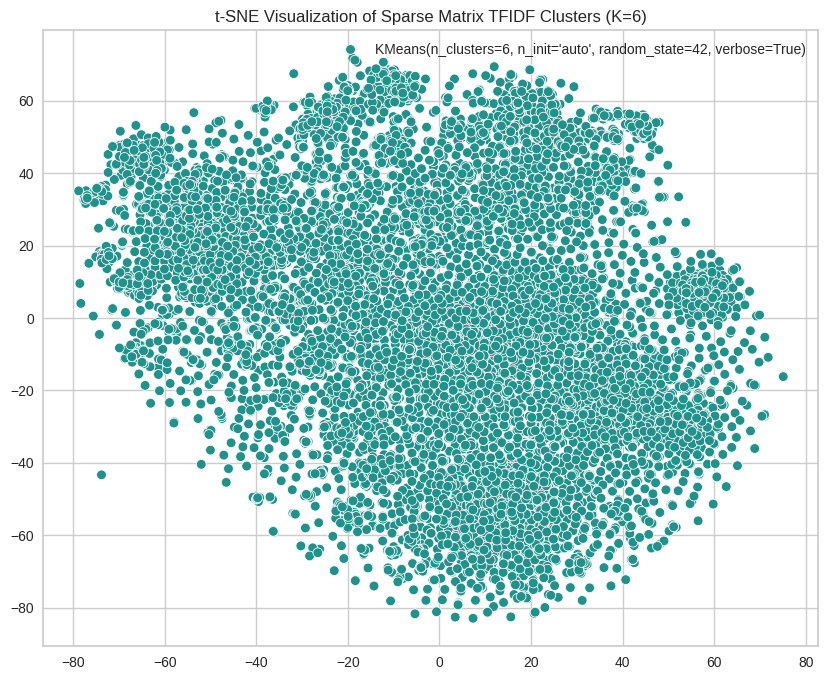

In [45]:
# use tsne to plot clusters of cluster_model_2 for k=6

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
doc_embeddings_tsne = tsne.fit_transform(doc_matrix.toarray())

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=doc_embeddings_tsne[:, 0], y=doc_embeddings_tsne[:, 1], hue=cluster_model_2, palette="viridis")
plt.title("t-SNE Visualization of Sparse Matrix TFIDF Clusters (K=6)")
plt.show()


Summary:
* Yikes! A sparse Matrix is obviously not idea for clustering. It is very difficult to discern the clusters of our text documents.
* This is why we will look at using transformers below for a more optimal result.

# A different approach: Clustering with Transformers + Embeddings

## First define a DistilBERT Transformer using HuggingFace

In [26]:
!pip install transformers --quiet

In [27]:
## import torch and huggingface
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

In [28]:
## define device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
## define transformer model
class model(nn.Module):
  def __init__(self, checkpoint, freeze=False, device=device):
    super().__init__()

    # define model and model weights import from huggingface
    self.model = AutoModel.from_pretrained(checkpoint)
    hidden_sz = self.model.config.hidden_size ## dont need hidden state but leave it here for now
    # set device
    self.device = device
    # freeze model
    if freeze:
      for layer in self.model.parameters():
        layer.requires_grade=False #do not require gradients -- do not perform backpropagation during forward pass


  # define forward pass - 'x' is our data
  def forward(self, x, attention_mask=None):

    # send to device
    x = x.to(self.device)
    # pool_output(seq, dim) -- torch.no_grad --> turn off back propagation
    with torch.no_grad():
      ## model output from tokenizer --> dictionary of input_ids + attention_masks
      model_out = self.model(x['input_ids'], x['attention_mask'], return_dict=True)

    # get model logits from last hidden state --> this will do the same - model_out[0][:,0]
    embeds = model_out.last_hidden_state
    # mean pooling --> sum of embeddings / attention_mask
    mean_pool = embeds.sum(axis=1) / x['attention_mask'].sum(axis=1).unsqueeze(axis=1)
    return mean_pool

In [31]:
## setup model import from huggingface
checkpoint = 'distilbert-base-uncased'
distilbert = model(checkpoint, freeze=True)

# send model to device
distilbert.to(device)

# set tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Create Custom Data Loader for creating embeddings using DistilBERT

In [35]:
## time it
%%time

## custom data loader
## 2 lists - temporary embeddings, final embeddings
final_embeddings  = list()
all_embeddings = []

# pass all documents to variable
final_sentences = docs

# batch size
batch_sz = 64 ## can change this
# loop through idx --> 0 to final length, by batch_size
for idx in range(0, len(final_sentences), batch_sz):
  # create the batch of sentences
  batch_sentences = final_sentences[idx:idx+batch_sz]
  # for every sentence in batch of sentences
  for sent in batch_sentences:
    # 1. tokenize input
    tokens = tokenizer(sent, truncation='longest_first', return_tensors='pt', return_attention_mask=True, padding=True)
    # 2. create embeddings
    embeddings = distilbert(tokens)
    # 3. append temporary embeddings
    final_embeddings.extend(embeddings)
    # 4. get finalized embeddings
    all_embeddings = torch.stack(final_embeddings)

CPU times: user 1min 58s, sys: 187 ms, total: 1min 58s
Wall time: 1min 58s


## Fit custom embeddendings on best KMeans Model
* We will use the best model from above which was a k=6 or `cluster_model_2`

In [36]:
## fit embeddings to best model above
clustered_docs = cluster_model_2.fit_predict(all_embeddings.cpu())

Initialization complete
Iteration 0, inertia 163067.7993443952.
Iteration 1, inertia 102240.20698692599.
Iteration 2, inertia 99819.70224813242.
Iteration 3, inertia 98843.91785656413.
Iteration 4, inertia 98354.84595719178.
Iteration 5, inertia 98142.36980009402.
Iteration 6, inertia 98008.7764961834.
Iteration 7, inertia 97905.4005598429.
Iteration 8, inertia 97833.39709193462.
Iteration 9, inertia 97785.1374806907.
Iteration 10, inertia 97753.55143519455.
Iteration 11, inertia 97737.63564516688.
Iteration 12, inertia 97729.21385556739.
Iteration 13, inertia 97723.2610205763.
Iteration 14, inertia 97719.82444319189.
Iteration 15, inertia 97718.62012618374.
Iteration 16, inertia 97717.63385295562.
Iteration 17, inertia 97716.88490995285.
Iteration 18, inertia 97716.20019885997.
Iteration 19, inertia 97715.83964961946.
Iteration 20, inertia 97715.62861290321.
Iteration 21, inertia 97715.4056803427.
Iteration 22, inertia 97715.2631649175.
Iteration 23, inertia 97715.21999375169.
Iterati

## Evaluate embeddings on best cluster model

In [37]:
## evaluate purity
purity(labels, clustered_docs)

0.8056068490851099

In [38]:
## evaluate adjusted_rand_score
adjusted_rand_score(labels, clustered_docs)

0.5894608523254066

Summary:
* Looks like immediately we can see improvement in the purity and the adjusted_rand_score by using custom embeddings via DistilBERT.
* The purity from our best TFIDF model was 71% and it is now 80.5%.
* The adjusted_rand_score from our best TFIDF model was 38% and it is now 58.9%.

## Visualize the Embeddings using TSNE

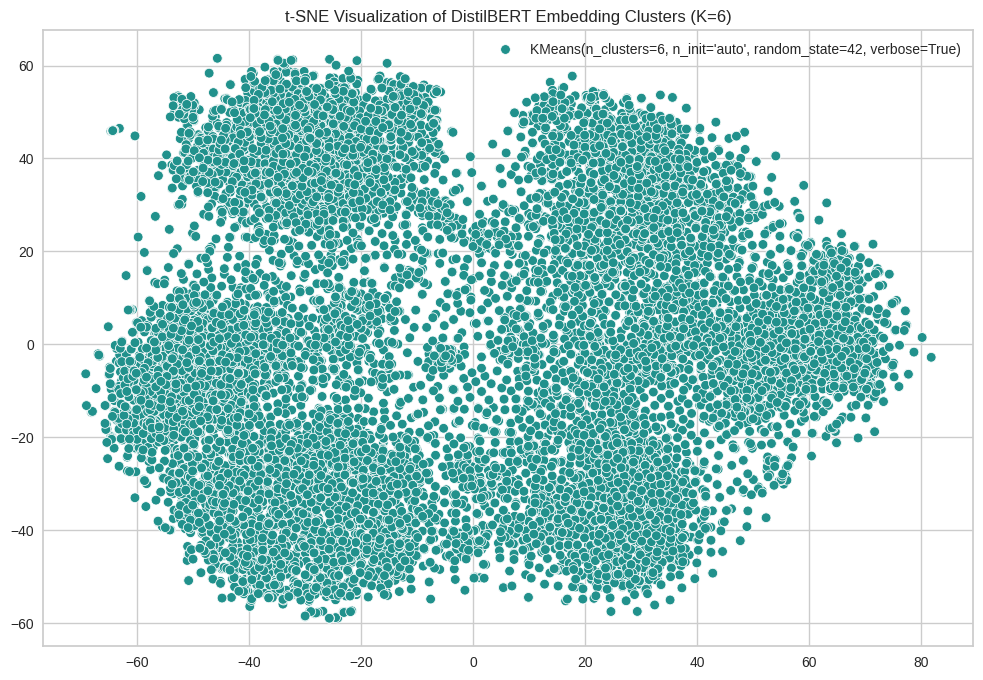

In [44]:
# use tsne to plot clusters of cluster_model_2 for k=6
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne_2 = TSNE(n_components=2, random_state=42)
doc_embeddings_tsne_2 = tsne_2.fit_transform(all_embeddings.cpu())

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=doc_embeddings_tsne_2[:, 0], y=doc_embeddings_tsne_2[:, 1], hue=cluster_model_2, palette="viridis")
plt.title("t-SNE Visualization of DistilBERT Embedding Clusters (K=6)")
plt.show()


Summary:
* We can now see there are **well defined clusters** using TSNE that were not visible before using the classical TFIDF sparse matrix method.
* It appears there are 4 distinct clusters with some outliers.
* We would have to do some additional work to extract these clusters into defined sets to distinctly compare them.

# Experiment 3 - Lets use the embeddings to find the best K

In [40]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
## fit a KMeans model to start
cluster_model_embed = KMeans(n_clusters=6, random_state=42, n_init="auto", verbose=True)
# fit_predict
cluster_docs_embed = cluster_model_embed.fit_predict(all_embeddings.cpu())

Initialization complete
Iteration 0, inertia 163067.79934439523.
Iteration 1, inertia 102240.20698692597.
Iteration 2, inertia 99819.70224813242.
Iteration 3, inertia 98843.91785656413.
Iteration 4, inertia 98354.84595719176.
Iteration 5, inertia 98142.36980009399.
Iteration 6, inertia 98008.7764961834.
Iteration 7, inertia 97905.4005598429.
Iteration 8, inertia 97833.39709193463.
Iteration 9, inertia 97785.13748069068.
Iteration 10, inertia 97753.55143519453.
Iteration 11, inertia 97737.63564516688.
Iteration 12, inertia 97729.2138555674.
Iteration 13, inertia 97723.2610205763.
Iteration 14, inertia 97719.82444319187.
Iteration 15, inertia 97718.62012618374.
Iteration 16, inertia 97717.63385295562.
Iteration 17, inertia 97716.88490995285.
Iteration 18, inertia 97716.20019885997.
Iteration 19, inertia 97715.83964961948.
Iteration 20, inertia 97715.62861290322.
Iteration 21, inertia 97715.4056803427.
Iteration 22, inertia 97715.2631649175.
Iteration 23, inertia 97715.21999375167.
Iterat

Initialization complete
Iteration 0, inertia 188664.4685675238.
Iteration 1, inertia 113299.93388994501.
Iteration 2, inertia 111320.42222460458.
Iteration 3, inertia 110063.30218388955.
Iteration 4, inertia 109607.93546405162.
Iteration 5, inertia 109537.33693381226.
Iteration 6, inertia 109529.68566091584.
Iteration 7, inertia 109528.33477243123.
Iteration 8, inertia 109527.78505580236.
Iteration 9, inertia 109527.6216706282.
Iteration 10, inertia 109527.55757299408.
Iteration 11, inertia 109527.51967908897.
Converged at iteration 11: center shift 5.775793908960663e-07 within tolerance 1.2988508168609294e-06.
Initialization complete
Iteration 0, inertia 181707.10371628683.
Iteration 1, inertia 110278.98357394477.
Iteration 2, inertia 107990.91591717287.
Iteration 3, inertia 106652.21067511529.
Iteration 4, inertia 106279.87560104596.
Iteration 5, inertia 106221.42029361217.
Iteration 6, inertia 106199.34020387933.
Iteration 7, inertia 106185.3547855493.
Iteration 8, inertia 106178.57

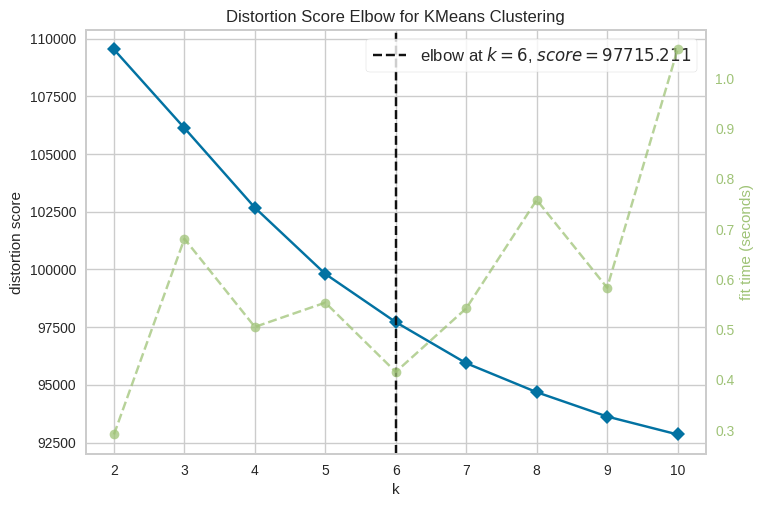

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
# use the new cluster embedding model
visualizer_2 = KElbowVisualizer(cluster_model_embed, k=(2,11))

# fit embeddings to
visualizer_2.fit(all_embeddings.cpu())    # Fit the data to the visualizer
visualizer_2.show()

In [42]:
## evaluate purity
purity(labels, cluster_docs_embed)

0.8056068490851099

In [43]:
## eval adjusted_rand_score
adjusted_rand_score(labels, cluster_docs_embed)

0.5894608523254066

# Summary
* Just as I thought, the result was the same as using our best model `cluster_model_2` because the k value is the same.
* There are some other methods we could use to improve our clustering such as:
1. Using other clustering methods with the custom embeddings, including but not limited to:
   * spectral clustering
   * spectral RBF clustering
   * DBSCAN
   * Affinity propagation clustering
   * Agglomerative clustering

2. Use alternative methods to find the best K value including:
   * Elbow Method
   * Silhouette Method
   * Gap Statistic Method
   * Additional algorithms that are open source via the yellowbrick API

3. Fine-tune other hyperparameters
4. Try other open source embedding models freely available on HuggingFace as well as trying different SentenceTransformer models.
5. We can also look at different techniques to reduce the dimensionality of the clusters and evaluate them besides TSNE, such as NMF.
6. It is clear though from this exercise that classical TFIDF sparse matrices do not perform well on highly dense text such as the dataset that we used and that is why embeddings are generally better. Having said that, there may be times when TFIDF or sparse matrices are more userful in situations where keyword or NER search is performed but thats a completely separate issue to explore in another notebook.